# Rag From Scratch: Query Transformations

Query transformations are a set of approaches focused on re-writing and / or modifying questions for retrieval.

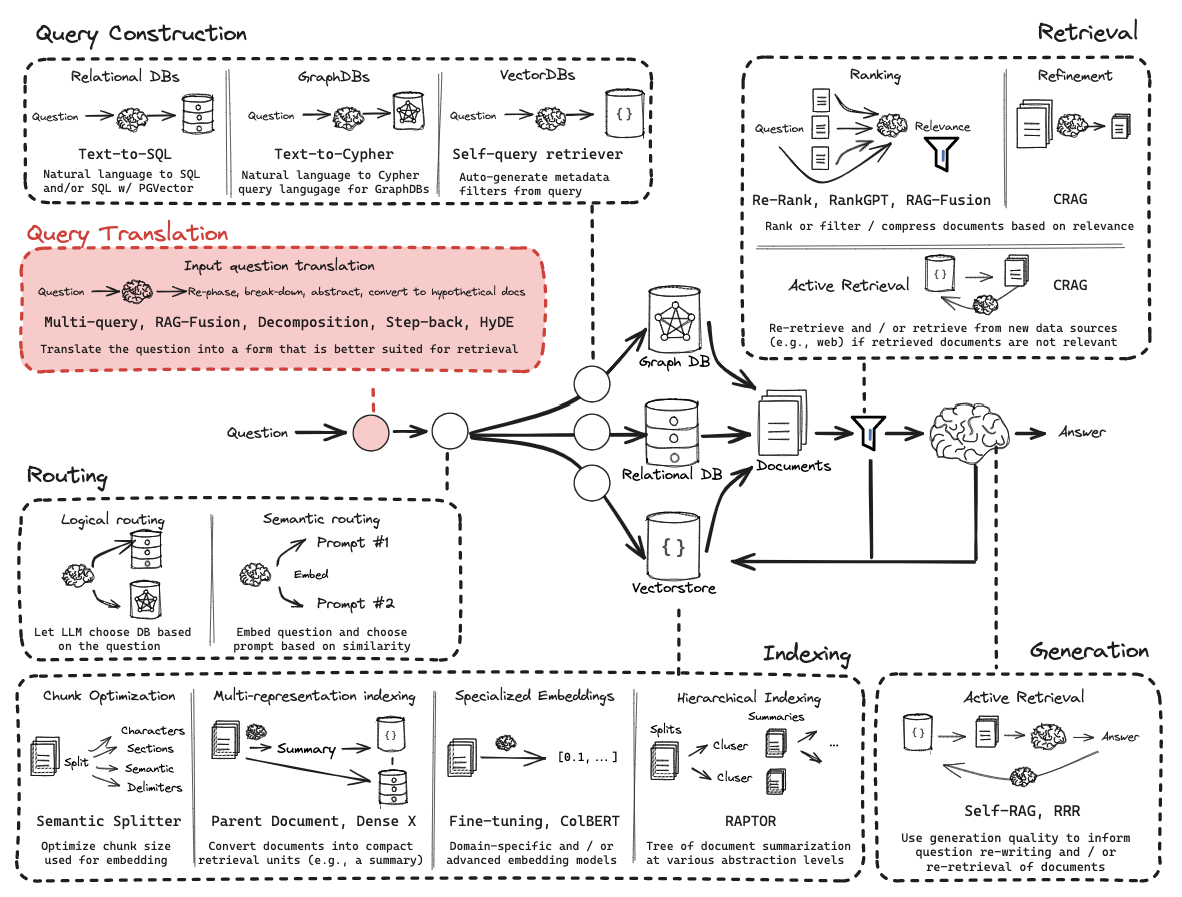

## Enviornment

`(1) Packages`

In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain

`(2) LangSmith`

https://docs.smith.langchain.com/

In [3]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'

`(3) API Keys`

In [4]:
import getpass
os.environ['LANGCHAIN_API_KEY'] = getpass.getpass()
os.environ["OPENAI_API_KEY"] = getpass.getpass()

## Part 5: Multi Query

Flow:

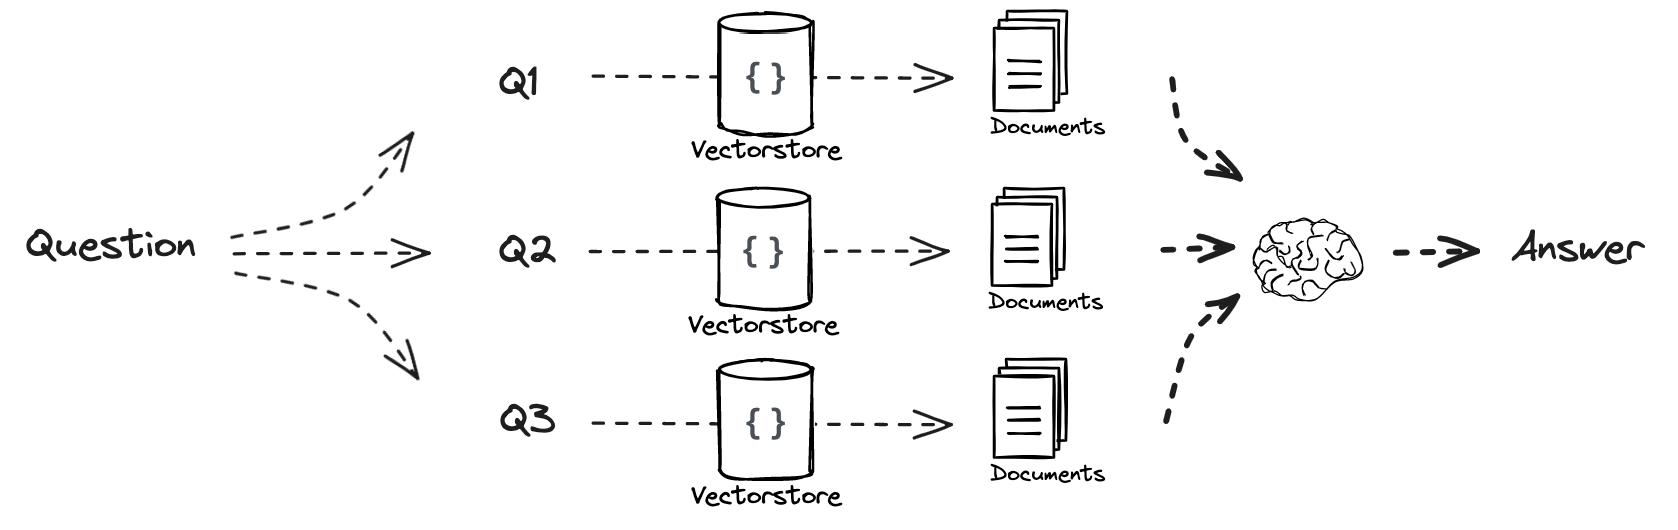

Docs:

* https://python.langchain.com/docs/modules/data_connection/retrievers/MultiQueryRetriever

### Index

In [5]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

# Index
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

In [9]:
# checking split overlap
print(splits)

[Document(page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n

not sure why but `splits` doesn't seem to show overlap (supposedly `chunk_overlap=50`)
```
[Document(page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}), 

Document(page_content='Memory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.\nLong-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.\n\n\nTool use\n\nThe agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources and more.', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}), 

Document(page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps
```

### Prompt

In [15]:
# note: the "multi" in multi-query is only defined in the template here which is passed through the rest of the chain. the code is flexible wrt to number of queries

from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [11]:
print(generate_queries)

first=ChatPromptTemplate(input_variables=['question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], template='You are an AI language model assistant. Your task is to generate five \ndifferent versions of the given user question to retrieve relevant documents from a vector \ndatabase. By generating multiple perspectives on the user question, your goal is to help\nthe user overcome some of the limitations of the distance-based similarity search. \nProvide these alternative questions separated by newlines. Original question: {question}'))]) middle=[ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7f6314319b10>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7f634a8f3a60>, temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy=''), StrOutputParser()] last=RunnableLambda(...)


`generate_queries` structure
```
first=ChatPromptTemplate(
    input_variables=['question'], 
    messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], template='You are an AI language model assistant. Your task is to generate five \ndifferent versions of the given user question to retrieve relevant documents from a vector \ndatabase. By generating multiple perspectives on the user question, your goal is to help\nthe user overcome some of the limitations of the distance-based similarity search. \nProvide these alternative questions separated by newlines. Original question: {question}'))
    ]
) 
middle=[
    ChatOpenAI(
        client=<openai.resources.chat.completions.Completions object at 0x7f6314319b10>,                   async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7f634a8f3a60>, 
        temperature=0.0, 
        openai_api_key=SecretStr('**********'), openai_proxy=''), 
    StrOutputParser()
]
last=RunnableLambda(...)
```

In [16]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

6

LangSmith trace:

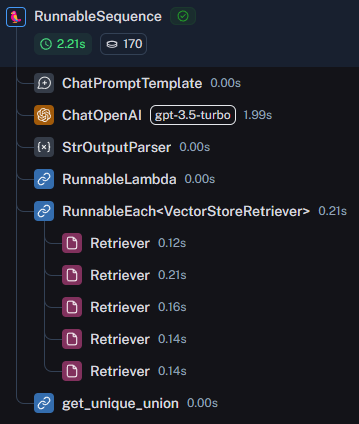

In [17]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(temperature=0)

# this is a "chain of chains" kind of bc retrieval_chain is also chain... neat
# retrieval chain returns unique union of docs surfaced by the multi-query
# which is fed to LLM, only one response generated
final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks. This allows the agent to plan ahead and tackle the task step by step, improving the quality of the final results.'

LangSmith trace:

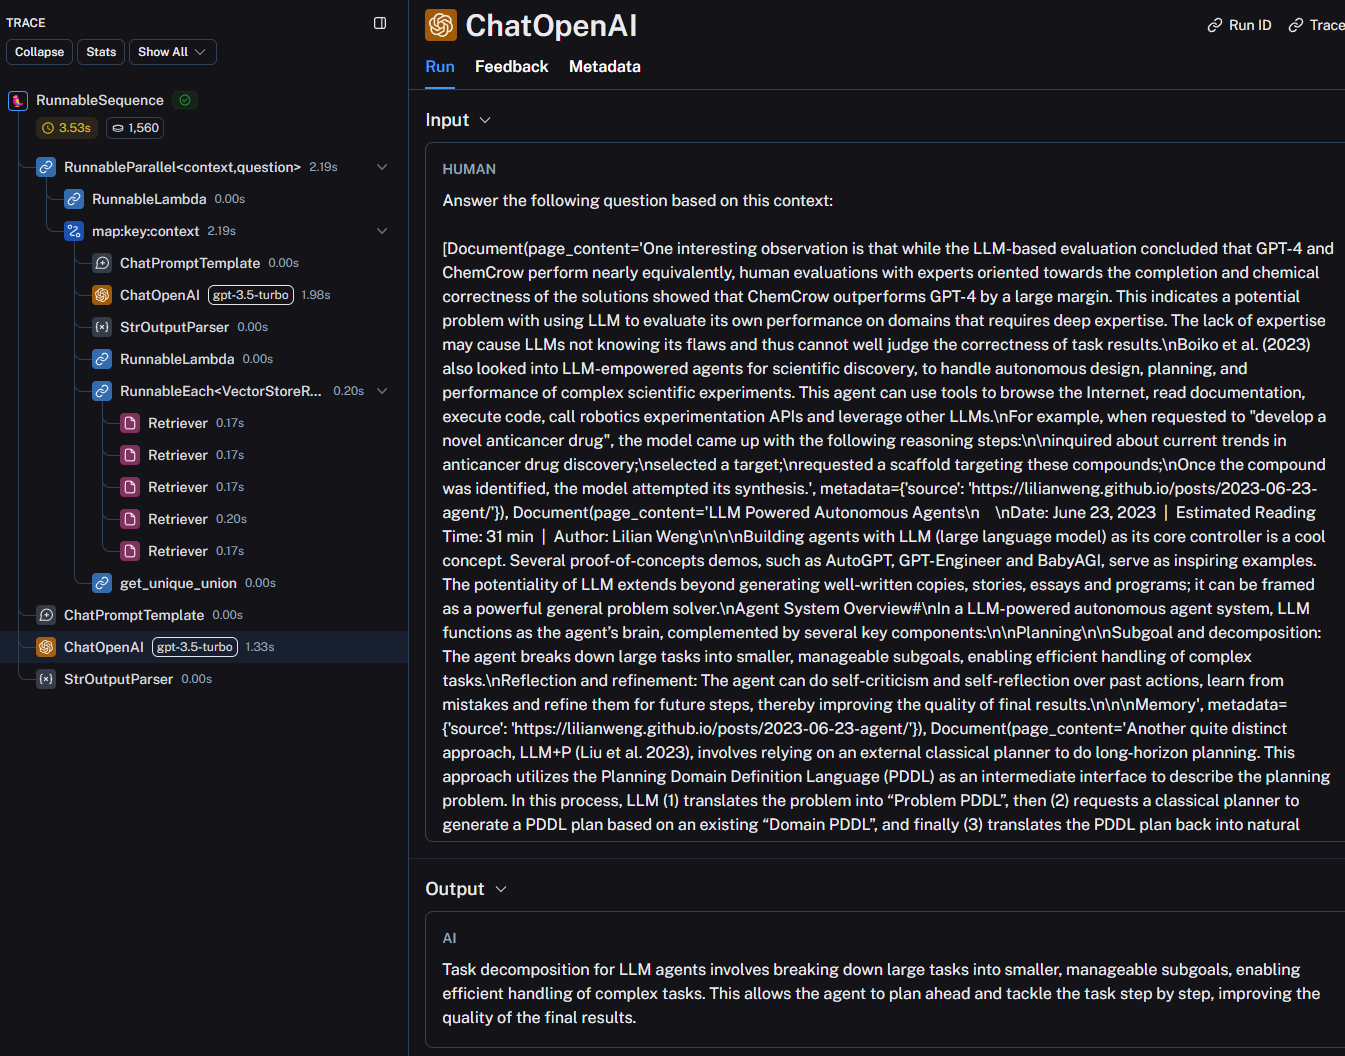

## Part 6: RAG-Fusion

Flow:

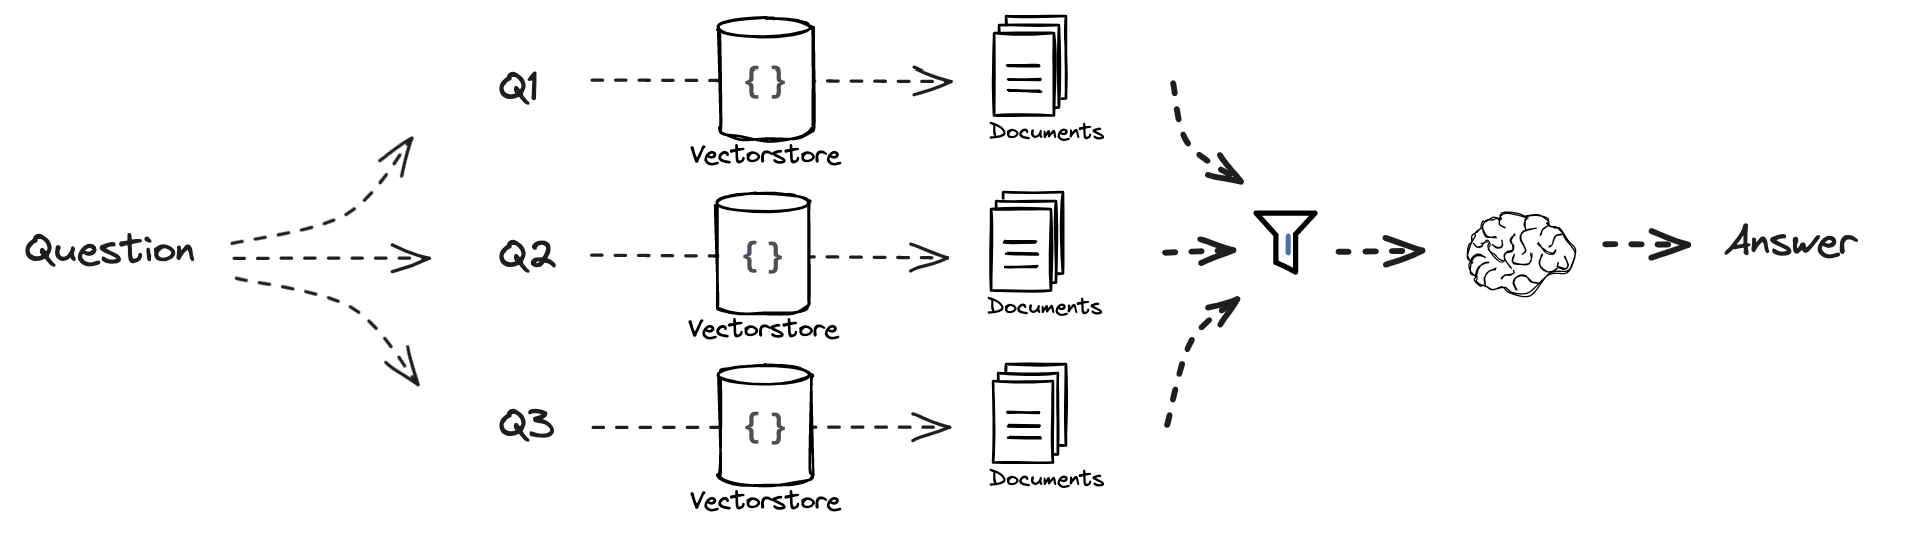

Docs:

* https://github.com/langchain-ai/langchain/blob/master/cookbook/rag_fusion.ipynb?ref=blog.langchain.dev

Blog / repo: 

* https://towardsdatascience.com/forget-rag-the-future-is-rag-fusion-1147298d8ad1

### Prompt

In [18]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [19]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_rag_fusion 
    | ChatOpenAI(temperature=0)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [20]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

7

LangSmith trace with rerank score added, best chunk wins

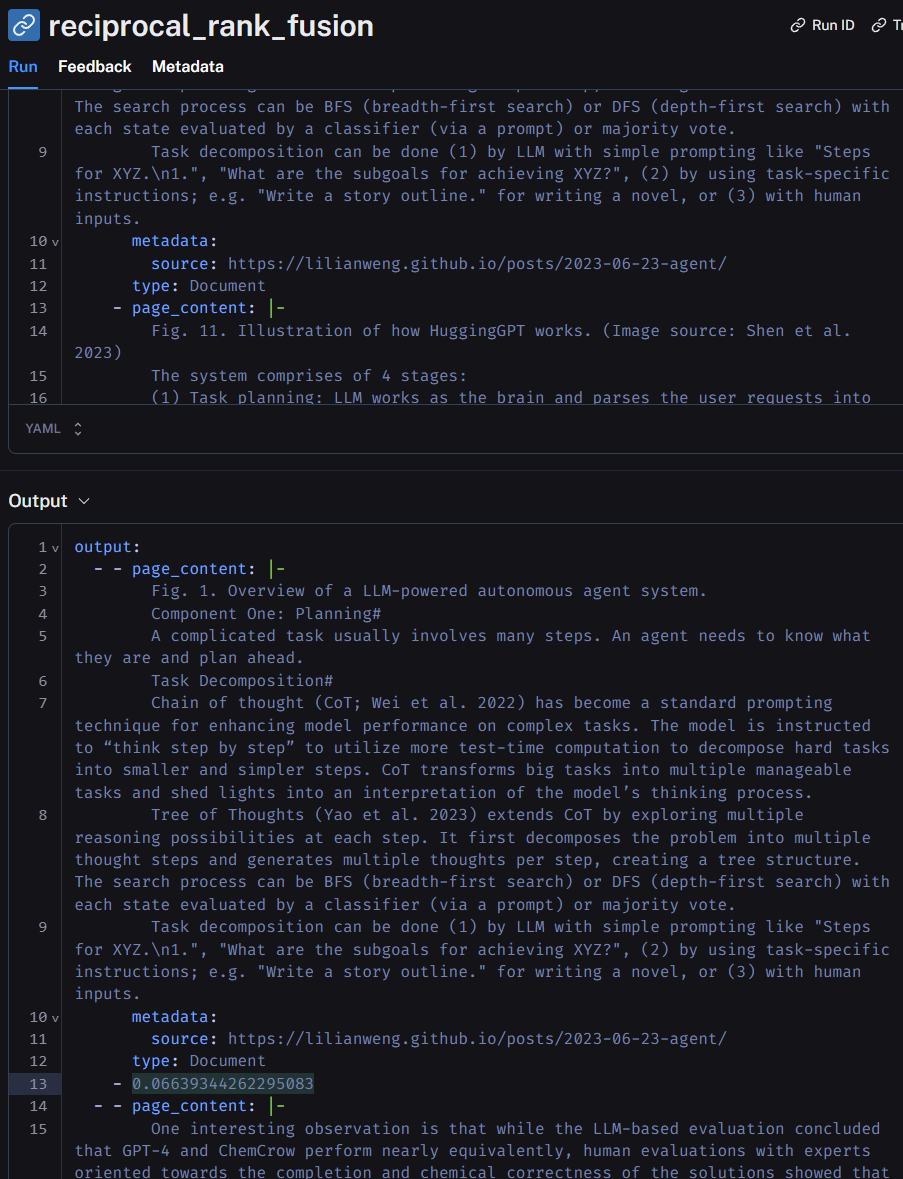

In [21]:
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals. This enables the agent to efficiently handle complex tasks by dividing them into more easily achievable steps.'

Trace:

https://smith.langchain.com/public/071202c9-9f4d-41b1-bf9d-86b7c5a7525b/r

LangSmith trace showing generation step. Not immediately clear how presence of rank score influences model. If all it does is make sure best chunk is first in context, not clear how being at the top of the context improves chances of good answer... in fact that would be a bad feature in the LLMs

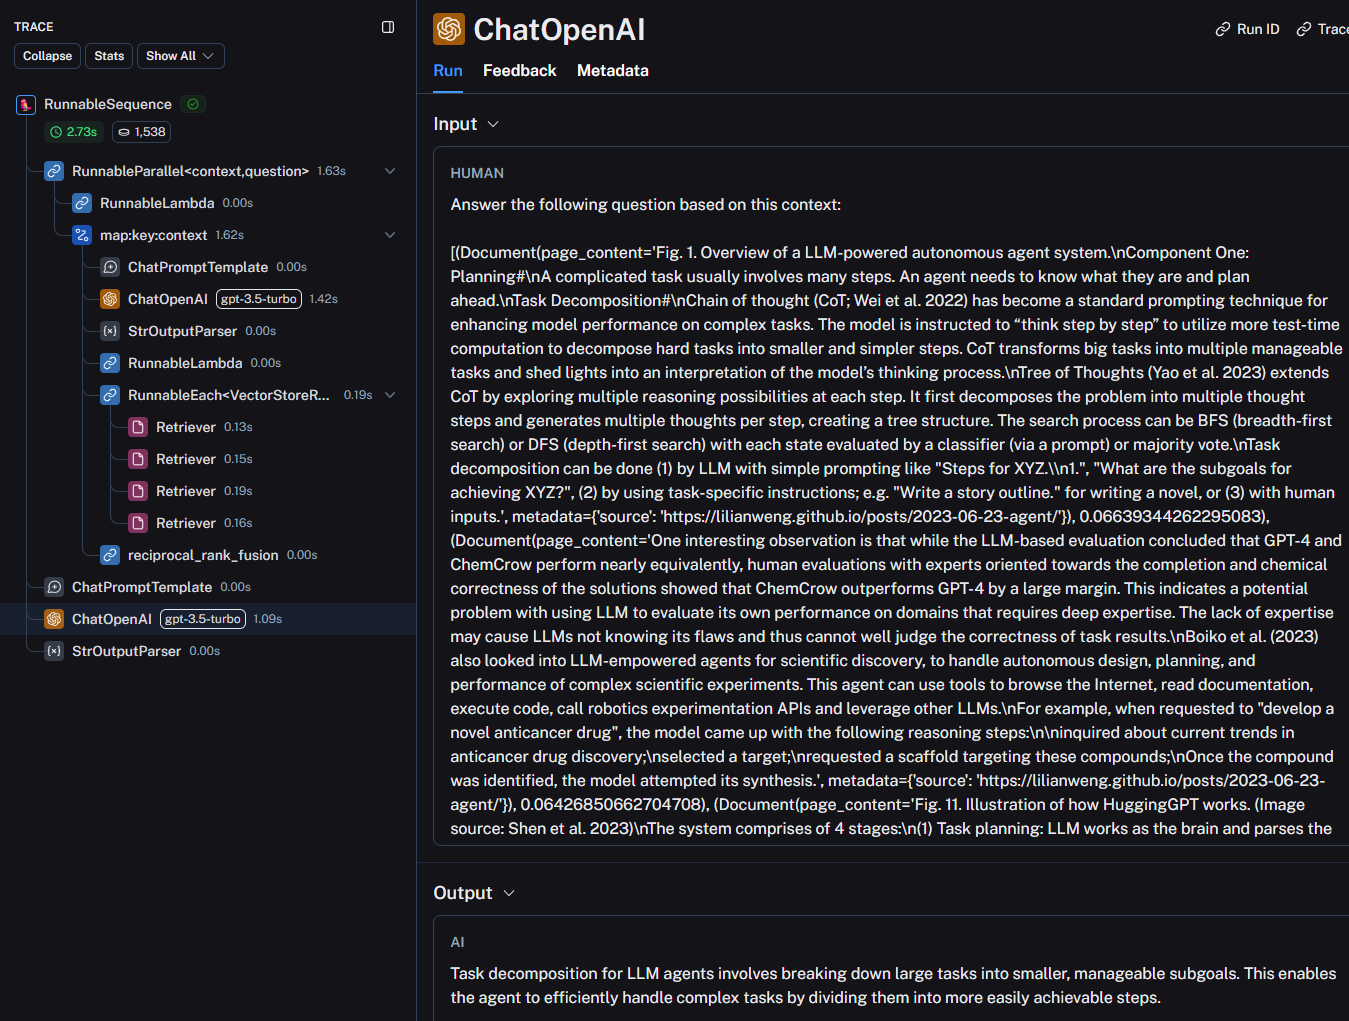

## Part 7: Decomposition

In [22]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [23]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = ChatOpenAI(temperature=0)

# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question":question})

In [24]:
questions

['1. What is LLM technology and how does it work in autonomous agent systems?',
 '2. What are the specific components that make up an LLM-powered autonomous agent system?',
 '3. How do the main components of an LLM-powered autonomous agent system interact with each other to enable autonomous behavior?']

### Answer recursively  

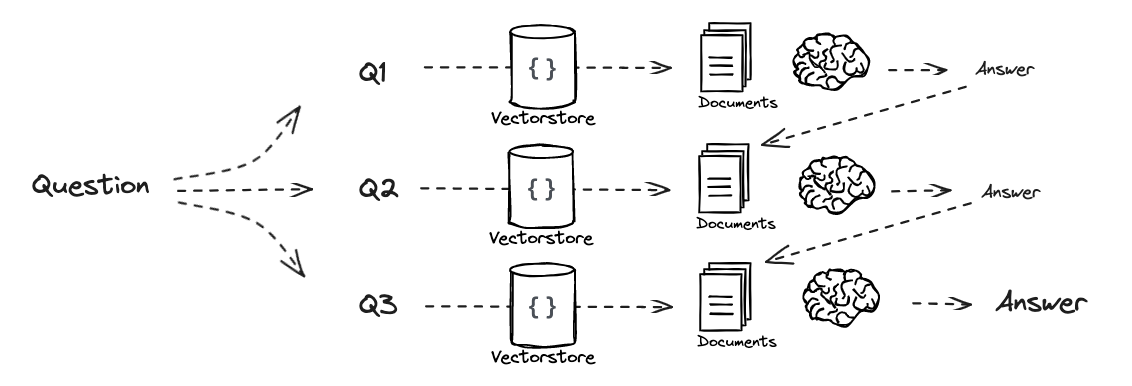

Papers:

* https://arxiv.org/pdf/2205.10625.pdf
* https://arxiv.org/abs/2212.10509.pdf

In [25]:
# note: this takes the question, any previous question answer pairs, and the retrieved docs

# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [26]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# llm
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# loop in here to answer all sub-questions, each time adding generated QA pair to list for next pass to feed in as context
q_a_pairs = ""
for q in questions:
    
    rag_chain = (
    {"context": itemgetter("question") | retriever, 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [9]:
answer

'The main components of an LLM-powered autonomous agent system interact with each other in a coordinated manner to enable autonomous functionality. \n\n1. Planning: The agent breaks down complex tasks into smaller subgoals through task decomposition. This allows for efficient handling of tasks by breaking them down into manageable steps. The agent can also engage in self-reflection and refinement, learning from past actions and improving future results.\n\n2. Memory: The agent stores information and past experiences to inform future actions. This memory component helps the agent make informed decisions based on past experiences.\n\n3. External Classical Planner (LLM+P approach): In some cases, the agent may outsource long-horizon planning to an external classical planner using the Planning Domain Definition Language (PDDL) as an intermediate interface. This allows for more complex planning tasks to be handled efficiently.\n\n4. Self-Reflection (ReAct approach): The agent integrates rea

LangSmith trace of this process

Creating the sub-queries:
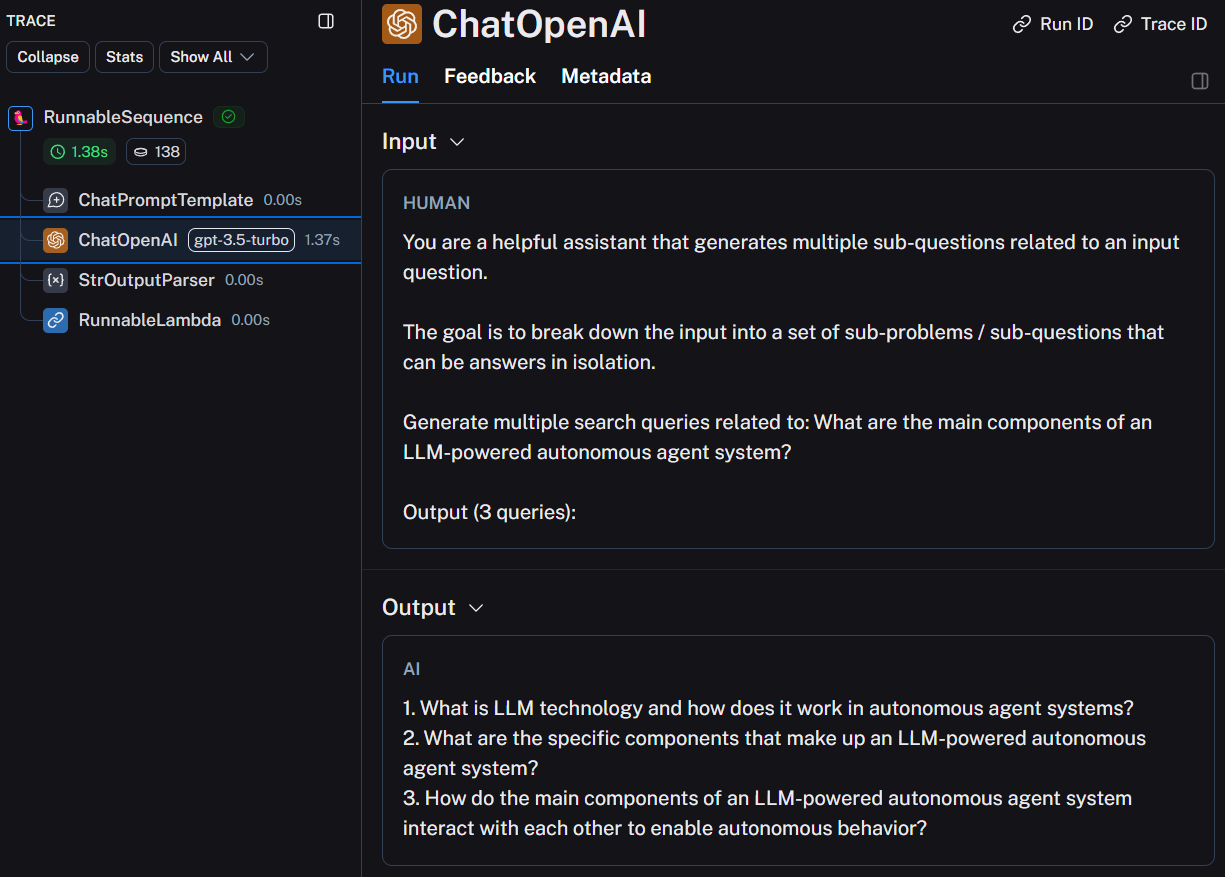

Question 1:
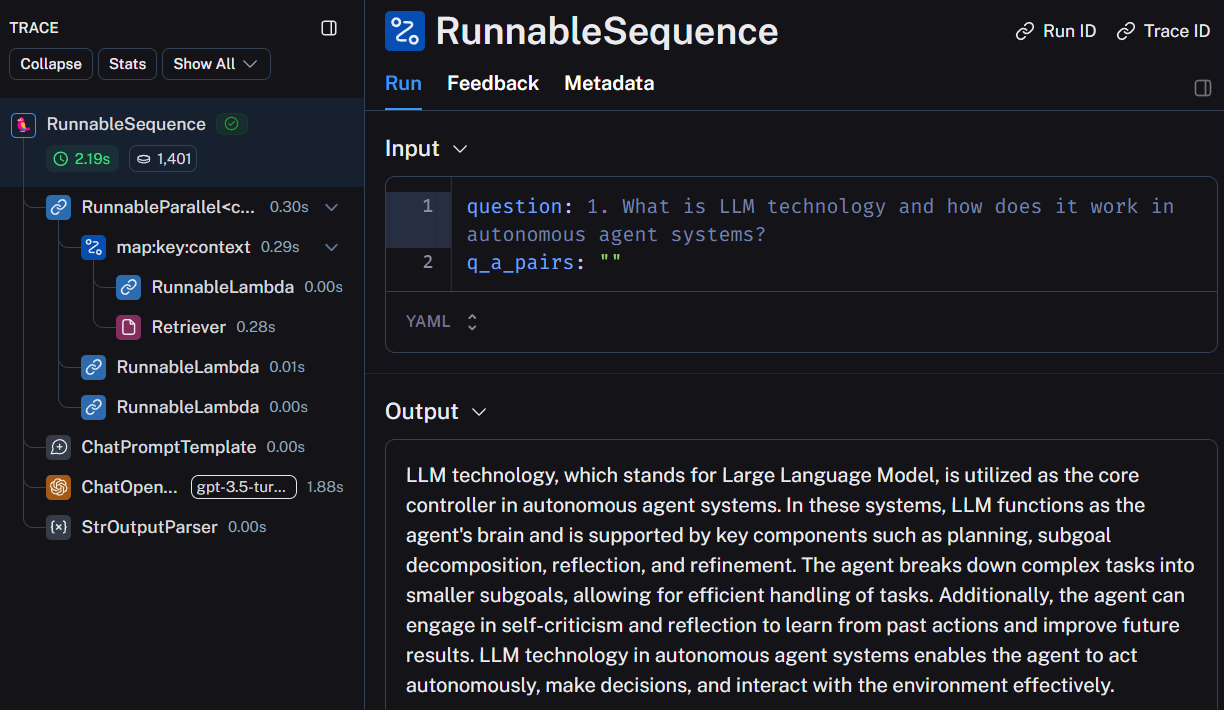

Question 2 (now includes previous QA pair):
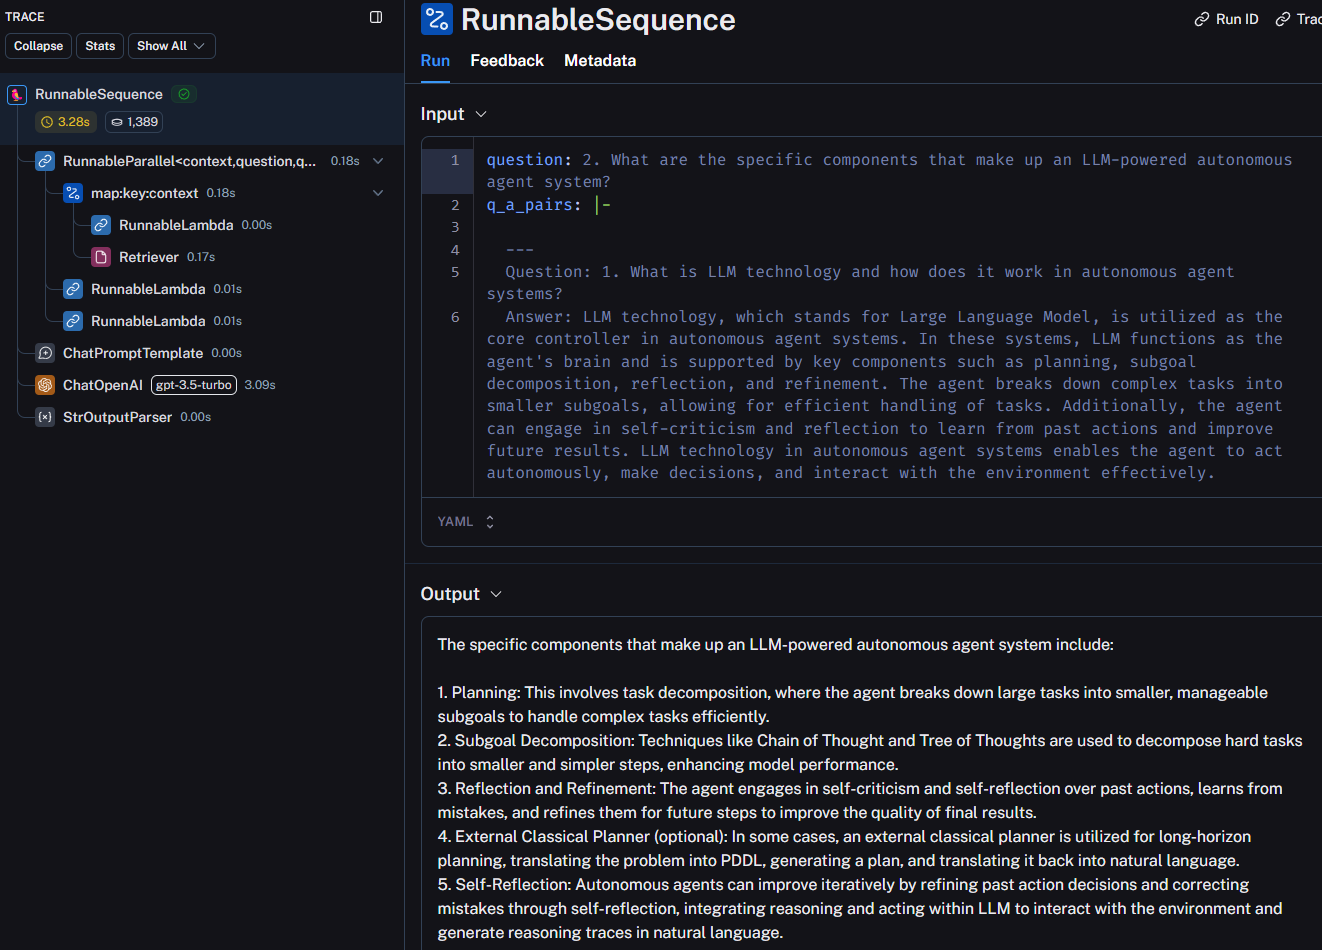

Question 3 same idea

Trace: 

Question 1: https://smith.langchain.com/public/faefde73-0ecb-4328-8fee-a237904115c0/r

Question 2: https://smith.langchain.com/public/6142cad3-b314-454e-b2c9-15146cfcce78/r

Question 3: https://smith.langchain.com/public/84bdca0f-0fa4-46d4-9f89-a7f25bd857fe/r

### Answer individually 

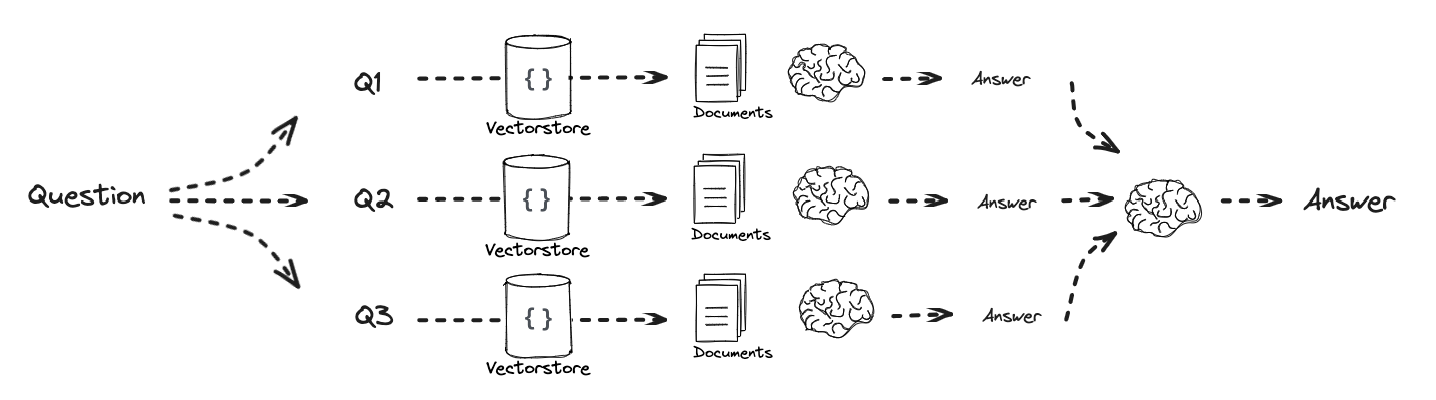

Rather than feeding prior QA into subsequent questions and generating the user output at the last step, an alternative approach is to answer each question separately and synthesizing an answer from the individual answer

Maybe better if sub-questions don't depend on each other

In [ ]:
# Answer each sub-question individually 

from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# RAG prompt
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain):
    """RAG on each sub-question"""
    
    # Use our decomposition / 
    sub_questions = sub_question_generator_chain.invoke({"question":question})
    
    # Initialize a list to hold RAG chain results
    rag_results = []
    
    for sub_question in sub_questions:
        
        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)
        
        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs, 
                                                                "question": sub_question})
        rag_results.append(answer)
    
    return rag_results,sub_questions

# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

In [11]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""
    
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

context = format_qa_pairs(questions, answers)

# Prompt
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":context,"question":question})

'The main components of an LLM-powered autonomous agent system include planning, subgoal decomposition, reflection and refinement, memory, task decomposition, and self-reflection. Planning involves breaking down tasks into manageable subgoals, while reflection allows for self-criticism and learning from past actions. Task decomposition can be done through simple prompting by LLM, task-specific instructions, or human inputs. These components work together to enable autonomous behavior by allowing the agent to plan, learn from mistakes, and improve its actions over time.'

Trace:

https://smith.langchain.com/public/d8f26f75-3fb8-498a-a3a2-6532aa77f56b/r

## Part 8: Step Back

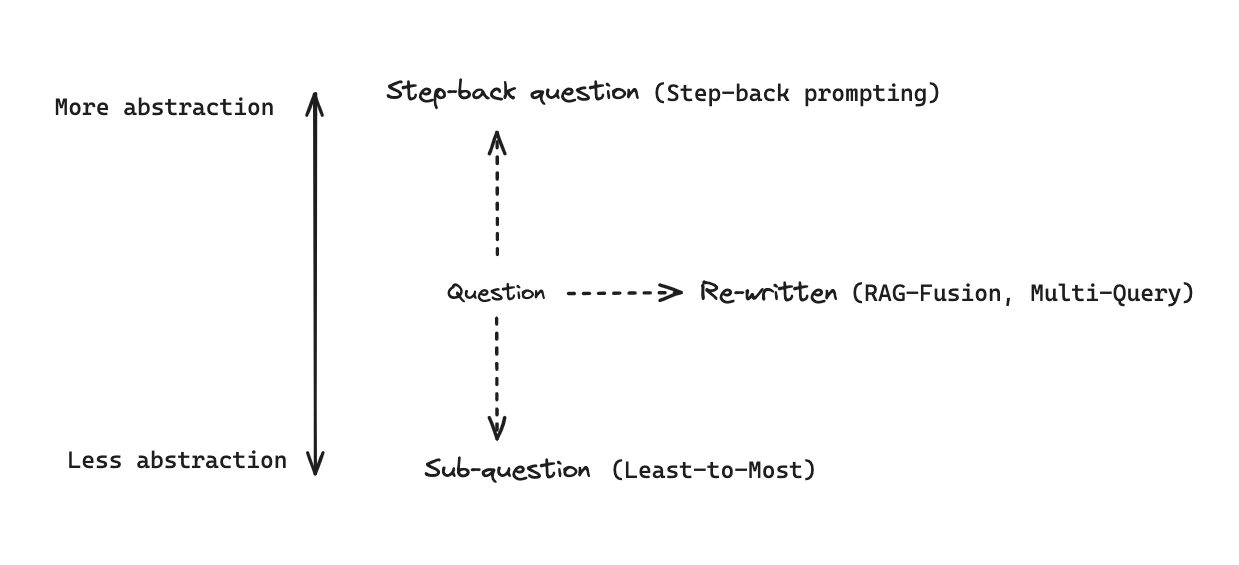

Paper: 

* https://arxiv.org/pdf/2310.06117.pdf

In [31]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

# note: these are examples from google paper
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]
# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

# system prompt that causes generation of step-back questions
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

In [32]:
generate_queries_step_back = prompt | ChatOpenAI(temperature=0) | StrOutputParser()
question = "What is task decomposition for LLM agents?"
generate_queries_step_back.invoke({"question": question})

'What is the process of breaking down tasks for LLM agents?'

note: in this case the step-back seems to be worse than the original prompt

In [33]:
# Response prompt 
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # Retrieve context using the step-back question
        "step_back_context": generate_queries_step_back | retriever,
        # Pass on the question
        "question": lambda x: x["question"],
    }
    | response_prompt
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
)

chain.invoke({"question": question})

'Task decomposition for LLM agents refers to the process of breaking down complex tasks into smaller, more manageable subgoals or steps. This approach allows LLM-powered autonomous agents to efficiently handle intricate tasks by dividing them into simpler components. Task decomposition is essential for planning and executing tasks effectively, as it enables the agent to focus on one subgoal at a time, leading to better overall performance.\n\nIn the context of LLM-powered autonomous agents, task decomposition can be achieved through various techniques. One common method is the use of prompting techniques such as Chain of Thought (CoT) and Tree of Thoughts. CoT prompts the model to "think step by step," encouraging it to decompose hard tasks into smaller steps. On the other hand, Tree of Thoughts extends CoT by exploring multiple reasoning possibilities at each step, creating a tree structure of thought processes. These techniques help the model transform complex tasks into multiple man

LangSmith trace. Step-back question is used to perform additional retrieval and then both sets of context are passed to model along with original question

## Part 9: HyDE

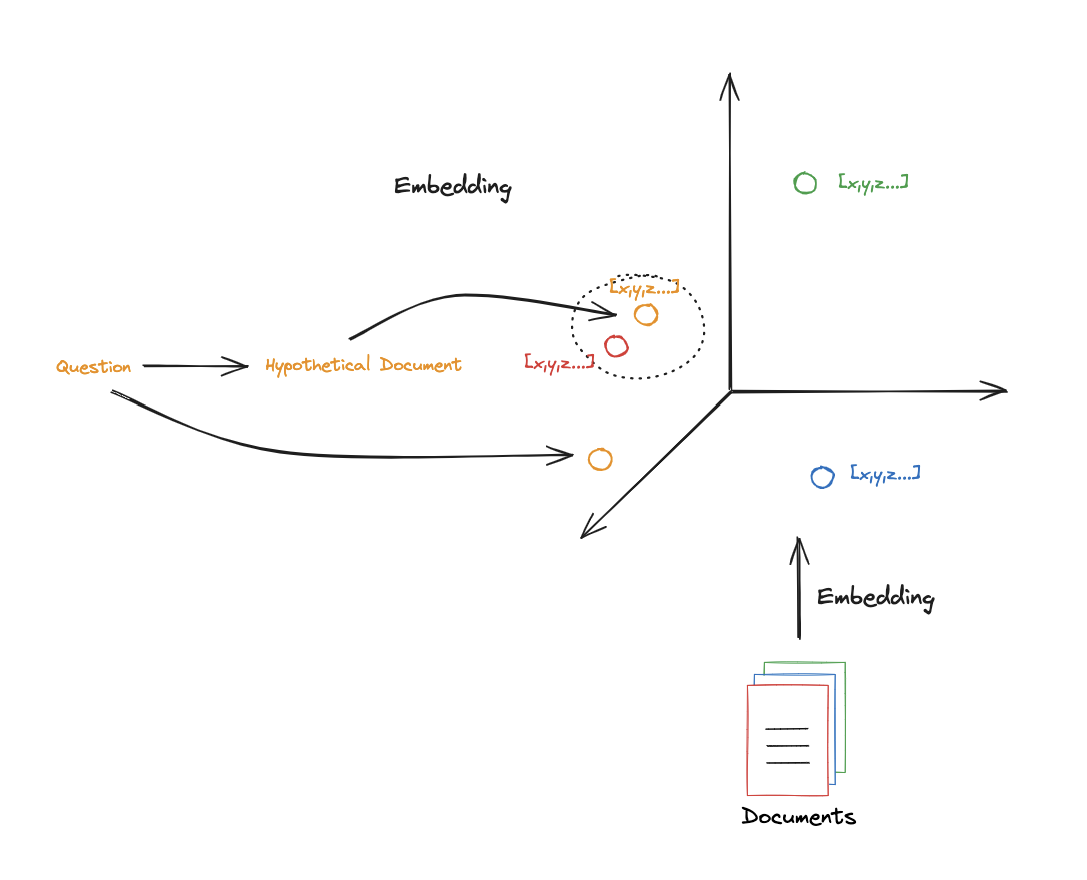

Docs: 

* https://github.com/langchain-ai/langchain/blob/master/cookbook/hypothetical_document_embeddings.ipynb

Paper:

* https://arxiv.org/abs/2212.10496

In [35]:
from langchain.prompts import ChatPromptTemplate

# HyDE document genration
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_docs_for_retrieval = (
    prompt_hyde | ChatOpenAI(temperature=0) | StrOutputParser() 
)

# Run
question = "What is task decomposition for LLM agents?"
generate_docs_for_retrieval.invoke({"question":question})

'Task decomposition is a fundamental concept in the field of reinforcement learning, particularly for Large Language Model (LLM) agents. Task decomposition refers to the process of breaking down a complex task into smaller, more manageable sub-tasks that can be solved independently. This approach allows LLM agents to effectively tackle large and complex problems by dividing them into smaller, more manageable components.\n\nBy decomposing a task into smaller sub-tasks, LLM agents can focus on solving each sub-task individually, which can lead to more efficient and effective problem-solving. Additionally, task decomposition can help LLM agents to better understand the underlying structure of a problem and identify the most important components that need to be addressed.\n\nOverall, task decomposition is a crucial strategy for LLM agents to effectively navigate complex tasks and achieve optimal performance. By breaking down tasks into smaller components, LLM agents can improve their probl

In [36]:
# Retrieve
retrieval_chain = generate_docs_for_retrieval | retriever 
retireved_docs = retrieval_chain.invoke({"question":question})
retireved_docs

[Document(page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via 

In [37]:
# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":retireved_docs,"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals. This enables the agent to efficiently handle complex tasks by dividing them into multiple manageable tasks, making it easier for the agent to process and execute the necessary steps.'